# Market Making with Q-Learning
## NO LATENCY
### Assumption: I can submit bid-ask quotes AFTER I see the current bidPrice and askPrice

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from time import perf_counter

Loading noise trades and week1 results

In [3]:
MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)

week1 = pd.read_csv('sample_data_20200901_1_train.csv', index_col = 0)

nextBid = (list(week1['bidPrice'])[1:] + [0])
nextOffer = (list(week1['offerPrice'])[1:] + [0])
week1['nextBid'] = nextBid
week1['nextOffer'] = nextOffer

In [4]:
MM_train['trade'] = 0

MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')

MM_train['qty'].fillna(0,inplace= True)

week1['trade'] = MM_train['trade'] * MM_train['qty']

week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2

In [5]:
week1 = week1.iloc[:-1,:]
week1.iloc[30:45]

,bidPrice,offerPrice,bidQty,offerQty,nextBid,nextOffer,trade,midPrice
time,,,,,,,,
30,100.35,100.45,99,53,100.35,100.45,0.0,100.4
31,100.35,100.45,55,74,100.25,100.35,0.0,100.4
32,100.25,100.35,94,99,100.10,100.30,0.0,100.3
33,100.10,100.30,84,94,100.10,100.30,0.0,100.2
34,100.10,100.30,63,81,100.15,100.25,39.0,100.2
35,100.15,100.25,72,81,100.20,100.40,0.0,100.2
36,100.20,100.40,90,52,100.25,100.35,0.0,100.3
37,100.25,100.35,65,67,100.25,100.35,0.0,100.3
38,100.25,100.35,75,87,100.25,100.35,0.0,100.3


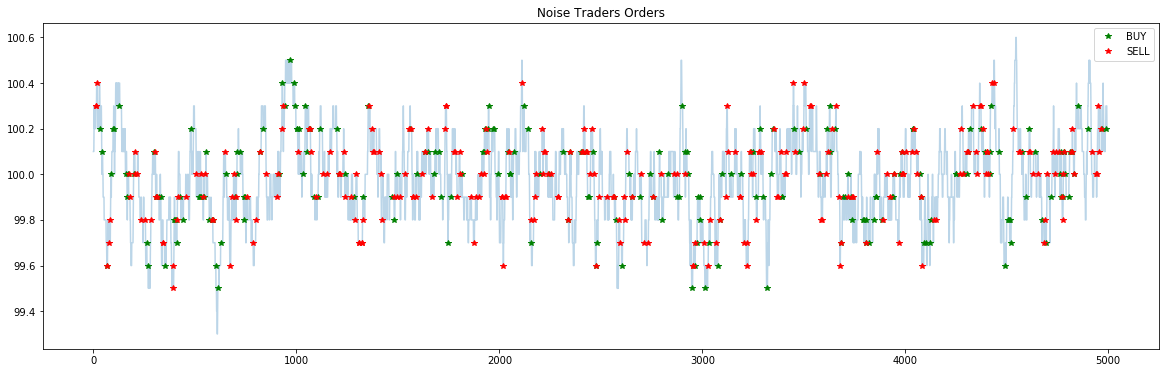

In [6]:
plt.figure(figsize = (20,6))
start_time = 0
end_time =  5000
plt.plot(week1['midPrice'][start_time:end_time],alpha=0.3)
plt.plot(week1[week1['trade'] > 0]['midPrice'].loc[start_time:end_time],'*',color = 'g', label='BUY')
plt.plot(week1[week1['trade'] < 0]['midPrice'].loc[start_time:end_time],'*',color = 'r',label='SELL')
plt.legend()
plt.title('Noise Traders Orders')
plt.show();

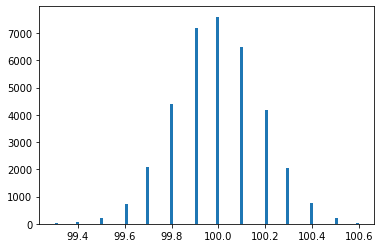

In [7]:
plt.hist(week1['midPrice'], bins = 100)
plt.show()

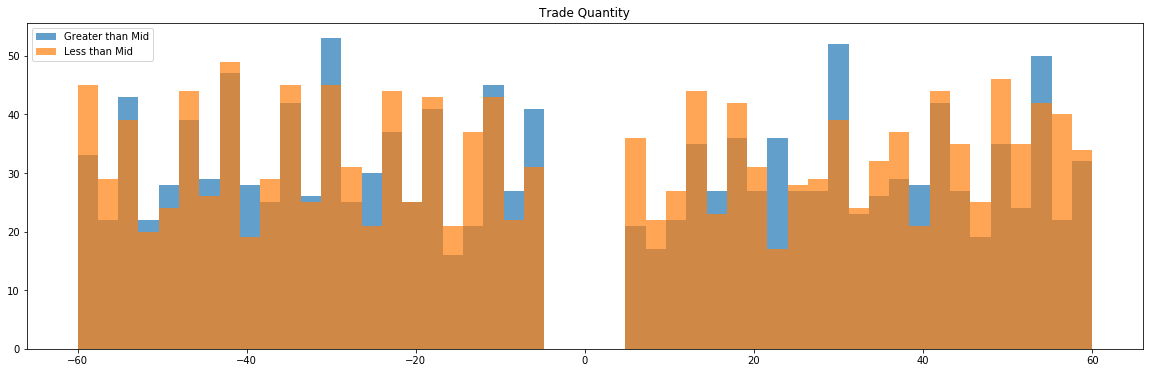

In [8]:
plt.figure(figsize=(20,6))
plt.hist(week1[(week1['trade'] != 0) & (week1['midPrice'] > 100)]['trade'] \
         , bins = 50, label = 'Greater than Mid', alpha = 0.7)
plt.hist(week1[(week1['trade'] != 0) & (week1['midPrice'] < 100)]['trade'] \
         , bins = 50, label = 'Less than Mid', alpha = 0.7)
plt.legend()
# plt.hist(week1[week1['trade'] < 0]['trade'], bins = 50)
plt.title('Trade Quantity')
plt.show();

Distribution seems pretty much same both side of the mid.

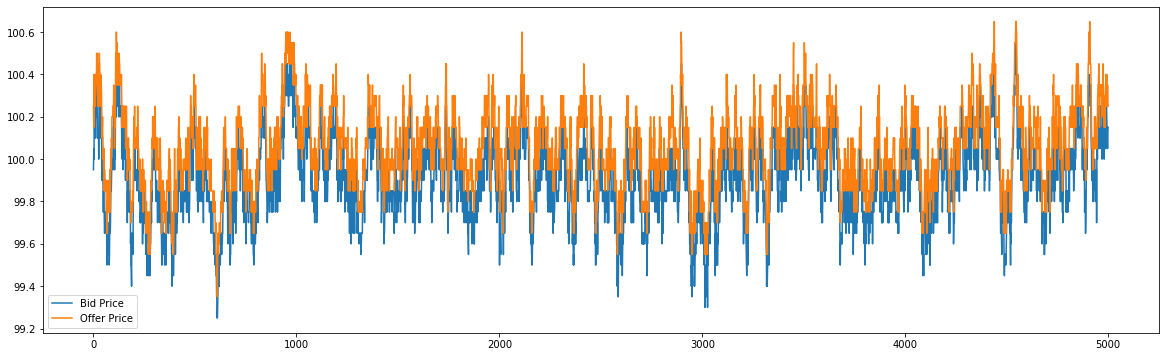

In [9]:
plt.figure(figsize=(20,6))
plt.plot(week1['bidPrice'][start_time:end_time],label = 'Bid Price')
plt.plot(week1['offerPrice'][start_time:end_time], label = 'Offer Price')
plt.legend()
plt.show()

# P&L Calculator for Market Making
## Based on inventory, calculate P&L when there's a reverse trade on inventory, e.g. having positive inventory but selling underlying or having negative inventory but buying underlying

In [154]:
def PnL_for_MM(data, bid, ask, clear):
    unr_pnl = 0
    pnls = []
    pnl = 0
    inventory = 0
    inventory_price = 0
    cash = 0
    count = 0
    inventory_record = []
    for i in range(len(data)):
        inventory_record.append(inventory)
        if clear[i]:
            if np.sign(inventory) > 0:
                pnl += inventory * (data['bidPrice'].iloc[i] - inventory_price)
                cash += inventory * data['bidPrice'].iloc[i]
            else:
                pnl += inventory * (data['offerPrice'].iloc[i] - inventory_price)
                cash -= abs(inventory) * data['offerPrice'].iloc[i]
            inventory_price = 0
            inventory = 0
            pnls.append(pnl)
            continue
        if data['trade'].iloc[i] > 0 :
            hit = (ask[i] < data['offerPrice'].iloc[i])
        else:
            hit = (bid[i] > data['bidPrice'].iloc[i])
        if hit:
            count += 1
            new_inventory = np.clip(inventory - data['trade'].iloc[i], -100, 100)
            amount_traded = new_inventory - inventory
            if inventory > 0:
                if amount_traded > 0:
                    inventory_price = (inventory_price * inventory + amount_traded * bid[i]) / new_inventory
                    inventory = new_inventory
                    cash -= amount_traded * bid[i]
                else:
                    if inventory > abs(amount_traded):
                        pnl += abs(amount_traded) * (ask[i] - inventory_price)
                        inventory = new_inventory
                        cash += abs(amount_traded) * ask[i]
                    else:
                        pnl += inventory * (ask[i] - inventory_price)
                        inventory_price = ask[i]
                        inventory = new_inventory
                        cash += abs(amount_traded) * ask[i]
            else:
                if amount_traded < 0:
                    inventory_price = (inventory_price * inventory + amount_traded * ask[i]) / new_inventory
                    inventory = new_inventory
                    cash += abs(amount_traded) * ask[i]
                else:
                    if abs(inventory) > amount_traded:
                        pnl += amount_traded * (inventory_price - bid[i])
                        inventory = new_inventory
                        cash -= amount_traded * bid[i]
                    else:
                        pnl += abs(inventory) * (inventory_price - bid[i])
                        inventory_price = bid[i]
                        inventory = new_inventory
                        cash -= amount_traded * bid[i]
        pnls.append(pnl)
    
#     clear inventory by market orders:
    b, a = data_['bidPrice'].iloc[-1], data_['offerPrice'].iloc[-1]
    if inventory > 0:
        cash_earned = cash + b * inventory
        pnl += (data_['bidPrice'].iloc[-1] - inventory_price) * inventory
    else:
        cash_earned = cash + a * inventory
        pnl += (inventory_price  - data_['offerPrice'].iloc[-1]) * inventory
    pnls.append(pnl)
    return pnls, cash_earned, count / len(data), inventory_record

In [133]:
MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
path = 'sample_data_20200901_1_train.csv'
week1 = pd.read_csv(path, index_col = 0)
MM_train['trade'] = 0
MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
MM_train['qty'].fillna(0,inplace= True)
week1['trade'] = MM_train['trade'] * MM_train['qty']
week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
week1 = week1.iloc[:-1,:]

In [134]:
data_ = week1.loc[week1['trade']!=0, :].copy()
data_.head()

,bidPrice,offerPrice,bidQty,offerQty,trade,midPrice
time,,,,,,
14,100.20,100.40,93,86,-37.0,100.3
15,100.20,100.40,75,91,-44.0,100.3
16,100.30,100.50,78,61,-12.0,100.4
34,100.10,100.30,63,81,39.0,100.2
43,100.05,100.15,91,99,53.0,100.1


# Human Trading

# Version 1.0
## As a market maker, I post constant bid-ask quotes all the time.

## Posting constant bid-ask all the time whenever there is a noise trader

In [237]:
bids = [99.95] * len(data_)
asks = [100.05] * len(data_)
clear = [False] * len(data_)
pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)

----------------------------
P&L in total is 2142.8999999998573
Standard deviation of P&L is 1.3208013736048516
----------------------------


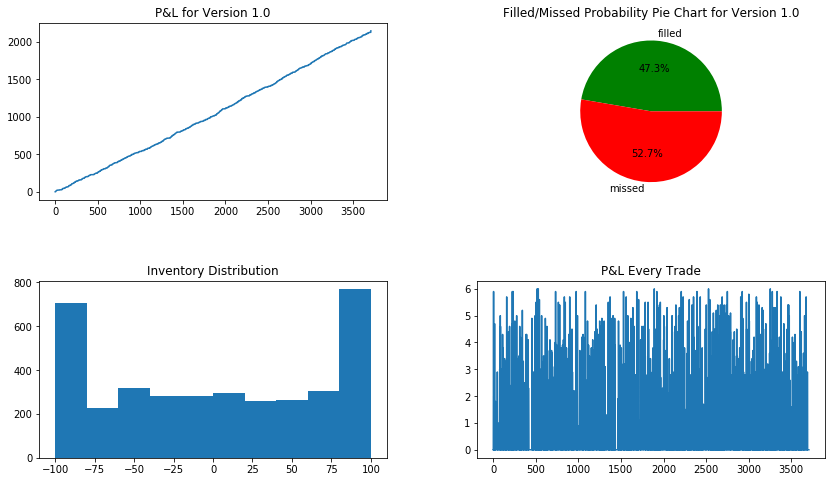

In [238]:
fig, axs = plt.subplots(2, 2,figsize=(13,8))
fig.tight_layout(pad=6.0)

axs[0][0].plot(pnls)
axs[0][0].set_title("P&L for Version 1.0")
axs[0][1].pie([hit_prob*100, 100-hit_prob*100], labels=['filled', 'missed'],autopct='%1.1f%%', colors=['green', 'red'])
axs[0][1].set_title('Filled/Missed Probability Pie Chart for Version 1.0')
axs[1][0].hist(inventory_record)
axs[1][0].set_title("Inventory Distribution")
axs[1][1].plot(np.diff(pnls)[:-1])
axs[1][1].set_title('P&L Every Trade')

print("----------------------------")
print("P&L in total is {}".format(pnls[-1]))
print("Standard deviation of P&L is {}".format(np.std(np.diff(pnls[:-1]))))
print("----------------------------")

# Version 2.0
## As a market maker, I post bid-ask with constant distance from mid price I observe

In [239]:
bid_spread = 0.05
ask_spread = 0.05
clear = [False] * len(data_)

In [242]:
bids = list(data_['midPrice']-bid_spread)
asks = list(data_['midPrice']+ask_spread)
pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)

----------------------------
P&L in total is 2862.599999999792
Standard deviation of P&L is 3.5474454996730747
2862.5999999997703
----------------------------


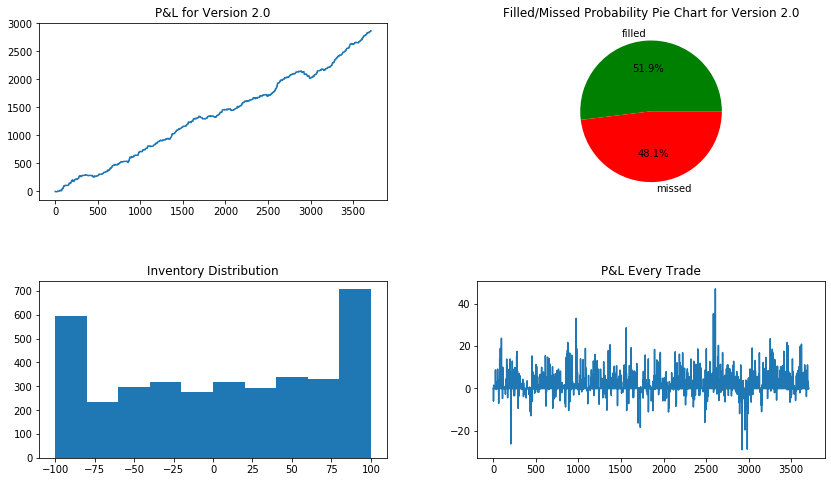

In [243]:
fig, axs = plt.subplots(2, 2,figsize=(13,8))
fig.tight_layout(pad=6.0)

axs[0][0].plot(pnls)
axs[0][0].set_title("P&L for Version 2.0")
axs[0][1].pie([hit_prob*100, 100-hit_prob*100], labels=['filled', 'missed'],autopct='%1.1f%%', colors=['green', 'red'])
axs[0][1].set_title('Filled/Missed Probability Pie Chart for Version 2.0')
axs[1][0].hist(inventory_record)
axs[1][0].set_title("Inventory Distribution")
axs[1][1].plot(np.diff(pnls)[:-1])
axs[1][1].set_title('P&L Every Trade')

print("----------------------------")
print("P&L in total is {}".format(pnls[-1]))
print("Standard deviation of P&L is {}".format(np.std(np.diff(pnls[:-1]))))
print(true_pnl)
print("----------------------------")

## Different bid-ask spread I make changes P&L and probability of getting the trades

The larger spreads I quote, the lower P&L I can realize, the probability of getting filled also decreases.

Text(0, 0.5, 'Probability of getting filled')

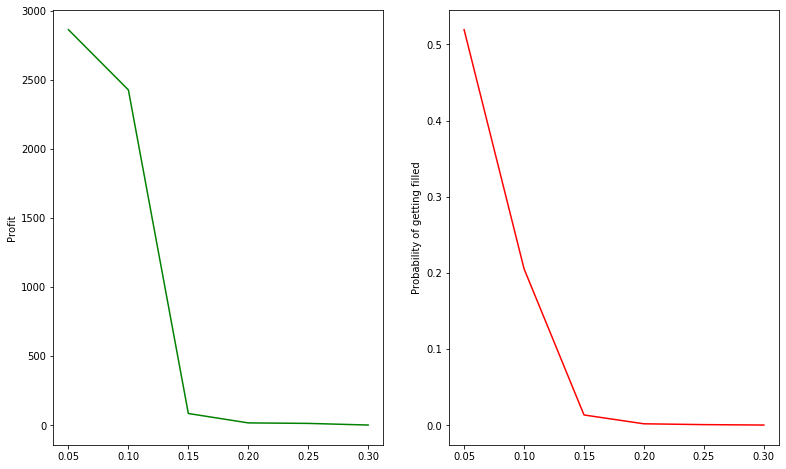

In [244]:
pl, probs = [], []
for i in np.arange(0.05, 0.35, 0.05):
    bid_spread = i
    ask_spread = i
    bids = list(data_['midPrice']-bid_spread)
    asks = list(data_['midPrice']+ask_spread)
    clear = [False] * len(data_)
    pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)
    pl.append(pnls[-1])
    probs.append(hit_prob)

fig, axs = plt.subplots(1, 2, figsize=(13,8))
spread = np.arange(0.05, 0.35, 0.05)
axs[0].plot(spread, pl, color='green')
axs[0].set_ylabel('Profit')
axs[1].plot(spread, probs, color='red')
axs[1].set_ylabel('Probability of getting filled')

# Q-Learning
## Environment

In [99]:
class MakerGame:
    def __init__(self, data, inventory_quote=False):
        self.data = data
        self.time = 0
        self.inventory = 0
        self.inventory_quote = inventory_quote
        self.inventory_price = 0
    
    def step(self, action):
        reward = 0
        pnl = 0
        if self.inventory_quote:
            pass
        else:
            if action == 9:
                if np.sign(self.inventory) > 0:
                    reward += self.inventory * (self.data['bidPrice'].iloc[self.time] - self.inventory_price)
                    pnl = self.inventory * (self.data['bidPrice'].iloc[self.time] - self.inventory_price)
                else:
                    reward += self.inventory * (self.data['offerPrice'].iloc[self.time] - self.inventory_price)
                    pnl = self.inventory * (self.data['offerPrice'].iloc[self.time] - self.inventory_price)
                self.inventory_price = 0
                self.inventory = 0
            else:
                diffs = action_space[action]
                bid, ask = self.data['midPrice'].iloc[self.time] - diffs[0], self.data['midPrice'].iloc[self.time] + diffs[1]
                if self.data['trade'].iloc[self.time] > 0 :
                    hit = (ask < self.data['offerPrice'].iloc[self.time])
                else:
                    hit = (bid > self.data['bidPrice'].iloc[self.time])
                if hit:
                    new_inventory = np.clip(self.inventory - self.data['trade'].iloc[i], -100, 100)
                    amount_traded = new_inventory - self.inventory
                    if self.inventory > 0:
                        if amount_traded > 0:
                            self.inventory_price = (self.inventory_price * self.inventory + amount_traded * bid) / new_inventory
                            self.inventory = new_inventory
                            third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                            reward = amount_traded * diffs[0] + (1-eta)* third_term

                        else:
                            if self.inventory > abs(amount_traded):
                                self.inventory = new_inventory
                                pnl = abs(amount_traded) * (ask - self.inventory_price)
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = abs(amount_traded) * diffs[1] + (1-eta)* third_term
                            else:
                                pnl = self.inventory * (ask - self.inventory_price)
                                self.inventory_price = ask
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = abs(amount_traded) * diffs[1] + (1-eta)* third_term

                    else:
                        if amount_traded < 0:
                            self.inventory_price = (self.inventory_price * self.inventory + amount_traded * ask) / new_inventory
                            self.inventory = new_inventory
                            third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                            reward = abs(amount_traded) * diffs[1] + (1-eta) * third_term

                        else:
                            if abs(self.inventory) > amount_traded:
                                pnl = amount_traded * (self.inventory_price - bid)
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = amount_traded * diffs[0] + (1-eta) * third_term

                            else:
                                pnl = abs(self.inventory) * (self.inventory_price - bid)
                                self.inventory_price = bid
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = amount_traded * diffs[0] + (1-eta) * third_term

            self.time += 1
            done = True if self.time == len(self.data) - 1 else False
        return (self.inventory, reward, pnl, done)

## Define the action space and inventory space.
## Parameters are chosen after some behind-the-scene experiment

In [214]:
action_space = [[0.05, 0.05], [0.1, 0.1], [0.15, 0.15], [0.2, 0.2], [0.25, 0.25], [0.05, 0.15], [0.15, 0.05], [0.1, 0.2], [0.2, 0.1]]

# first try action space only related to diff from mid price
ParamSpace = {
    'A_space': np.arange(10),
    'state_space': np.arange(-100, 101, 10)
}

def choose_action(state):
    rand = np.random.rand()
    if (rand < epsilon):
        action = np.random.choice(ParamSpace['A_space'], 1)[0]
    else:
        actions = Q_table[np.where(ParamSpace['state_space'] == state)[0], :]
        action = np.argmax(actions)
    return action


epsilon = 0.9
alpha, gamma = 0.1, 0.9
eta = 0.4

Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

r = []
action_list = []
t1 = perf_counter()
for ep in range(300):
    actions = []
    env = MakerGame(data_)
    state = env.inventory
    rewards_for_one_ep = []
    pnls_for_one_ep = []
    for i in range(len(data_)):
        state = 10*int(state / 10)
        act = choose_action(state)
        actions.append(act)
        next_state, reward, pnl, done = env.step(act)
        next_state = 10*int(next_state / 10)
        rewards_for_one_ep.append(reward)
        pnls_for_one_ep.append(pnl)
        q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
        maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
        increment = alpha * (reward + gamma * maxQ - q_sa)
        Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
        
        state = next_state

    epsilon *= 0.95
    r.append(sum(rewards_for_one_ep))
    action_list.append(actions)
#     print('done', ep)
t2 = perf_counter()
print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))

FINISHED. TIME ELAPSED: 100.11056225697394 seconds


### Reward function increases as episode grows and converges after certain episode

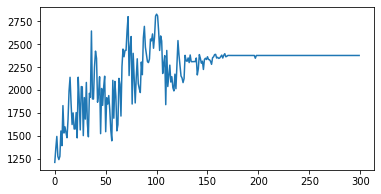

In [215]:
plt.figure(figsize = (6,3))
plt.plot(r)

### The trained agent chooses to take actions: post small spreads to win the trade, post large spreads to avoid trading, clear inventory

(array([1343.,  228.,    0.,    0.,    0.,    0.,    0.,    0., 1043.,
        1094.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

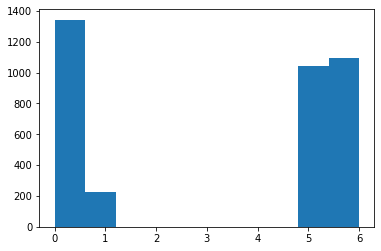

In [216]:
plt.hist(action_list[-1])

### Examine the result

In [217]:
action = action_list[-1]
bid_spread, ask_spread, clear = [], [], []
for i in range(len(action)):
    if action[i] == 9:
        bid_spread.append(0)
        ask_spread.append(0)
        clear.append(True)
    else:
        bid_spread.append(action_space[action[i]][0])
        ask_spread.append(action_space[action[i]][1])
        clear.append(False)
bids = list(data_['midPrice'] - np.array(bid_spread))
asks = list(data_['midPrice'] + np.array(ask_spread))
pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)

----------------------------
P&L in total is 2367.7999999998174
Standard deviation of P&L is 3.19816343121333
2367.799999999816
----------------------------


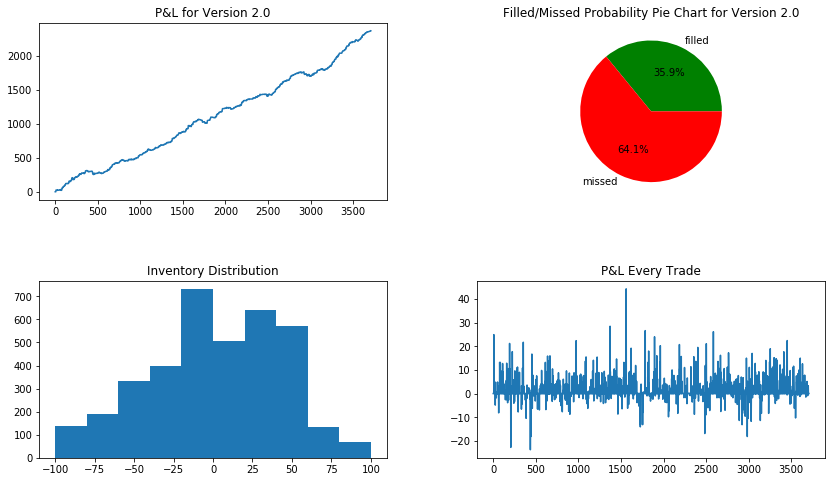

In [218]:
fig, axs = plt.subplots(2, 2,figsize=(13,8))
fig.tight_layout(pad=6.0)

axs[0][0].plot(pnls)
axs[0][0].set_title("P&L for Version 2.0")
axs[0][1].pie([hit_prob*100, 100-hit_prob*100], labels=['filled', 'missed'],autopct='%1.1f%%', colors=['green', 'red'])
axs[0][1].set_title('Filled/Missed Probability Pie Chart for Version 2.0')
axs[1][0].hist(inventory_record)
axs[1][0].set_title("Inventory Distribution")
axs[1][1].plot(np.diff(pnls)[:-1])
axs[1][1].set_title('P&L Every Trade')

print("----------------------------")
print("P&L in total is {}".format(pnls[-1]))
print("Standard deviation of P&L is {}".format(np.std(np.diff(pnls[:-1]))))
print(true_pnl)
print("----------------------------")

### From another dimension to see that inventory almost never reaches its limit, meaning that the inventory is well-controlled, which is part of the goal of a market maker.

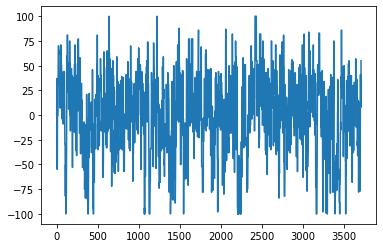

In [219]:
plt.plot(inventory_record)

### Studying the effect of different $\eta$ value's impact
The result shows that low $\eta$ encourages the agent to control the limit such that the number of times that inventory limit are reached decreases as $\eta$ increases.

The result also shows that high $\eta$, meaning that if we forfeit large portion of speculation profit, then the agent tends to post competitive quotes and win the trade, which further results in higher P&L. However, in this case, the agent has a tendency to keep more inventory.

Based on the observation, there is a trade-off between proper inventory control and absolute P&L the agent gets. Therefore, an optimal $\eta$ value should be chosen based on the specific market condition.

In [221]:
reward_list = []
action_list1 = []

pnl_list, inventory_boundary_list = [], []
for eta in np.arange(0, 1.01, 0.01):
    epsilon = 0.9
    alpha, gamma = 0.1, 0.9
#             eta = 1

    Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

    r = []
    action_list = []
    t1 = perf_counter()
    for ep in range(200):
        actions = []
        env = MakerGame(data_)
        state = env.inventory
        rewards_for_one_ep = []
        pnls_for_one_ep = []
        for i in range(len(data_)):
            state = 10*int(state / 10)
            act = choose_action(state)
            actions.append(act)
            next_state, reward, pnl, done = env.step(act)
            next_state = 10*int(next_state / 10)
            rewards_for_one_ep.append(reward)
            pnls_for_one_ep.append(pnl)
            q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
            maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
            increment = alpha * (reward + gamma * maxQ - q_sa)
            Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
            state = next_state

        epsilon *= 0.95
        r.append(sum(rewards_for_one_ep))
        action_list.append(actions)
    #     print('done', ep)
    t2 = perf_counter()
    print("FINISHED. eta = {} TIME ELAPSED: {} seconds".format(eta, t2-t1))
    reward_list.append(r)
    action_list1.append(action_list[-1])
    bid_spread, ask_spread, clear = [], [], []
    for i in range(len(action_list[-1])):
        if action_list[-1][i] == 9:
            bid_spread.append(0)
            ask_spread.append(0)
            clear.append(True)
        else:
            bid_spread.append(action_space[action_list[-1][i]][0])
            ask_spread.append(action_space[action_list[-1][i]][1])
            clear.append(False)
    bids = list(data_['midPrice'] - np.array(bid_spread))
    asks = list(data_['midPrice'] + np.array(ask_spread))
    pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)
    pnl_list.append(pnls[-1])
    inventory_boundary_list.append(inventory_record)

FINISHED. eta = 0.0 TIME ELAPSED: 60.42688497097697 seconds
FINISHED. eta = 0.01 TIME ELAPSED: 60.44735858097556 seconds
FINISHED. eta = 0.02 TIME ELAPSED: 60.8220906080096 seconds
FINISHED. eta = 0.03 TIME ELAPSED: 61.017801456997404 seconds
FINISHED. eta = 0.04 TIME ELAPSED: 59.54262765799649 seconds
FINISHED. eta = 0.05 TIME ELAPSED: 60.46467491000658 seconds
FINISHED. eta = 0.06 TIME ELAPSED: 59.82769920901046 seconds
FINISHED. eta = 0.07 TIME ELAPSED: 60.78565158799756 seconds
FINISHED. eta = 0.08 TIME ELAPSED: 59.61611403201823 seconds
FINISHED. eta = 0.09 TIME ELAPSED: 60.574556059989845 seconds
FINISHED. eta = 0.1 TIME ELAPSED: 60.20072938900557 seconds
FINISHED. eta = 0.11 TIME ELAPSED: 61.106778626010055 seconds
FINISHED. eta = 0.12 TIME ELAPSED: 60.687390787003096 seconds
FINISHED. eta = 0.13 TIME ELAPSED: 60.54249938900466 seconds
FINISHED. eta = 0.14 TIME ELAPSED: 61.00565445001121 seconds
FINISHED. eta = 0.15 TIME ELAPSED: 60.761252526019234 seconds
FINISHED. eta = 0.16 T

In [234]:
inventory_boundary_list1 = [np.sum(abs(np.array(inventory_boundary_list[i]))==100) for i in range(len(inventory_boundary_list))]

Text(0, 0.5, '# of Times Inventory Hits the Limit')

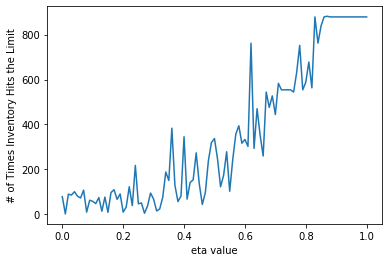

In [236]:
plt.plot(np.arange(0, 1.01, 0.01), inventory_boundary_list1)
plt.xlabel('eta value')
plt.ylabel('# of Times Inventory Hits the Limit')

Text(0, 0.5, 'P&L')

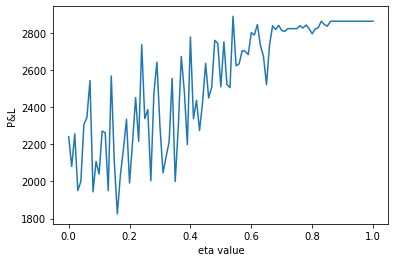

In [245]:
plt.plot(np.arange(0, 1.01, 0.01), pnl_list)
plt.xlabel('eta value')
plt.ylabel('P&L')